# TO DO
+ Encoder, decoder different sizes
+ Beam search
+ Data loader

In [1]:
import tarfile
import os
import pandas as pd
import keras
import numpy as np
from keras.layers import LSTM, Dense, Embedding, Input,GRU,SimpleRNN
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [2]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall() 

--2021-04-26 03:34:52--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  81.2MB/s    in 19s     

2021-04-26 03:35:11 (101 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



# Loading Data

In [3]:
class data_loader():

  @staticmethod
  def load_devanagiri():
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['input', 'output', 'count']

    languages = ['hi', 'mr']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def make_dataframe(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

    return lex

In [6]:
lex = data_loader.load_devanagiri()
lex = data_loader.make_dataframe(lex)

In [7]:
df = lex['train']

# Dataset Generation


In [4]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<STR>'
    self.stop_token = '<STP>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list = [self.encode_dict_input[self.start_token]] + [self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word] + [self.encode_dict_input[self.stop_token]]
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = [self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]]
        output_list.append(integer_list)
      
      return output_list
    

  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '0') for integer in integers[1:-1]] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '0') for integer in integers[1:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [8]:
tk = Tokenizer(df)

In [ ]:
tk.decode_dict_input

In [9]:
X_train = tk.encode(df.input.tolist())
print(X_train[:5])

[[1, 4, 5, 2], [1, 4, 5, 6, 7, 8, 9, 10, 2], [1, 4, 5, 6, 11, 2], [1, 4, 5, 6, 12, 13, 2], [1, 4, 5, 6, 12, 13, 8, 2]]


In [10]:
Y_train = tk.encode(df.output.tolist(), mode='output')
print(Y_train[:5])

[[1, 4, 5, 2], [1, 4, 5, 6, 7, 4, 5, 8, 9, 2], [1, 10, 5, 11, 12, 13, 2], [1, 4, 5, 6, 10, 14, 2], [1, 4, 5, 6, 10, 14, 4, 5, 2]]


In [11]:
X_val = tk.encode(lex['val'].input.tolist())
Y_val = tk.encode(lex['val'].output.tolist(),mode='output')

In [12]:
data = dict()
data['train'] = dict()
data['train']['X'] = X_train
data['train']['Y'] = Y_train
data['in_size'] = len(tk.input_corpus) + 1
data['out_size'] = len(tk.output_corpus) + 1
num_decoder_tokens = data['out_size'] 
max_source_length = np.max(np.array([len(x) for x in X_train]))
max_target_length = np.max(np.array([len(x) for x in Y_train]))

# Question 1


In [13]:
class rnn():

  def __init__(self, params):
    '''***************************************
    encoder_inputs = Input(shape=(None,))
    x = Embedding(data['in_size'], 64,mask_zero=True)(encoder_inputs)
    x = LSTM(units=256,return_sequences=True)(x)
    x, state_h, state_c = LSTM(units=256,
                              return_state=True)(x)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    decoder_embedding =  Embedding(data['out_size'], 64,mask_zero=True)
    x =decoder_embedding(decoder_inputs)
    decoder_LSTM = LSTM(units=256, return_sequences=True,return_state=True)
    x,_,_ = decoder_LSTM(x, initial_state=encoder_states)
    decoder_dense = Dense(units=data['out_size'], activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    *************************************************'''


    num_encode_layers = params['num_encode_layers']
    num_decode_layers = params['num_decode_layers']
    data = params['data']
    in_size = params['data']['in_size']
    out_size = params['data']['out_size']
    cell_type = params['cell_type']
    dropout = params['dropout']
    embed_size = params['embed_size']
    rep_size = params['rep_size']


    
    encoder_inputs = Input(shape=(None,))
    x = Embedding(data['in_size'], embed_size ,mask_zero=True)(encoder_inputs)
    encode_layers = []
    for j in range(num_encode_layers-1) :
      if cell_type == 'RNN' :
        curr_layer = layers.SimpleRNN(rep_size,dropout=dropout,return_sequences=True)
      elif cell_type == 'GRU' :
        curr_layer = layers.GRU(rep_size,dropout=dropout,return_sequences=True)
      elif cell_type == 'LSTM' :
        curr_layer = layers.LSTM(rep_size,dropout=dropout,return_sequences=True)

      encoder_layer.append(curr_layer)
      x = curr_layer(x)

    if cell_type == 'RNN' :
      curr_layer = layers.SimpleRNN(rep_size,dropout=dropout,return_state=True)
      encoder_layer.append(curr_layer)
      x, state_s = curr_layer(x)
      encoder_states = [state_s]
    elif cell_type == 'GRU' :
      curr_layer = layers.GRU(rep_size,dropout=dropout,return_state=True)
      encoder_layer.append(curr_layer)
      x, state_s = curr_layer(x)
      encoder_states = [state_s]
    elif cell_type == 'LSTM' :
      curr_layer = layers.LSTM(rep_size,dropout=dropout,return_state=True)
      encoder_layer.append(curr_layer)
      x, state_h,state_c = curr_layer(x)
      encoder_states = [state_h,state_c]
    
    
    decoder_inputs = Input(shape=(None,))
    decoder_layers = []
    decoder_embedding =  Embedding(data['out_size'],embed_size,mask_zero=True)
    x = decoder_embedding(decoder_inputs)
    

    for j in range(num_decode_layers) :
      if cell_type == 'RNN' :
        model.add(layers.SimpleRNN(rep_size,dropout=dropout,return_state=True, return_sequences=True))
        decoder_layers.append(curr_layer)
        x,_ = curr_layer(x,initial_state=encoder_states)
      elif cell_type == 'GRU' :
        model.add(layers.GRU(rep_size,dropout=dropout,return_state=True, return_sequences=True))
        decoder_layers.append(curr_layer)
        x,_ = curr_layer(x,initial_state=encoder_states)
      elif cell_type == 'LSTM' :
        model.add(layers.LSTM(rep_size,dropout=dropout,return_state=True, return_sequences=True))
        decoder_layers.append(curr_layer)
        x,_,_ = curr_layer(x,initial_state=encoder_states)
      
      

    decoder_dense = Dense(units=data['out_size'], activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    self.model = model
    self.encoder_inputs = encoder_inputs
    self.encode_layers = encode_layers
    self.decoder_inputs = decoder_inputs
    self.decoder_embedding = decoder_embedding
    self.decoder_layers = decoder_layers
    self.decoder_dense = decoder_dense
    self.encoder_states = encoder_states
    self.params = params

  def compile_and_fit(self,data,params):
    train_ds, val_ds = data['train'], data['val']
    optimizer, epochs = params['optimizer'], params['num_epochs']
    if optimizer == 'NAG' :
      optimizer = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)
    self.model.compile(optimizer=optimizer, 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy']
                       )
    
    summary = self.model.summary()

    run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                          patience=3, 
                                                                          min_delta=0.0025)]
                                 )

    return {
        'run_details' : run_details
    }


  def get_prediction(self,data,params,beam=1) :

    '''****************************************

    encoder_model = Model(encoder_inputs, encoder_states)
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(256,))
    decoder_state_input_c = Input(shape=(256,))
    decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
    # Get the embeddings of the decoder sequence
    dec_emb2 = decoder_embedding(decoder_inputs)
    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2
                                                        ,initial_state=decoder_state_input
                                                        )
    decoder_states2 = [state_h2, state_c2]
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    # Final decoder model
    decoder_model = Model(
        [decoder_inputs] + decoder_state_input,
        [decoder_outputs2] + decoder_states2)

    *****************************************************'''

    encoder_model = Model(self.encoder_inputs, self.encoder_states)
    rep_size = self.params['rep_size']
    decoder_state_input = []
    for i in range(len(self.encoder_states)) :
        new_state = Input(shape=(rep_size,))
        decoder_state_input.append(new_state)

    x = decoder_embedding(decoder_inputs)
    
    for layer in self.decoder_layers :
      x = layer(x,initial_state=decoder_state_input)

    



In [ ]:
params = {
    'num_encode_layers' : 1,
    'num_decode_layers' : 1,
    'cell type' : 'RNN' ,
    'data' : data,
    
    
}

In [63]:
encoder_inputs = Input(shape=(None,))
x = Embedding(data['in_size'], 64,mask_zero=True)(encoder_inputs)
x = LSTM(units=256,return_sequences=True)(x)
x, state_c,state_h = LSTM(units=256,
                           return_state=True)(x)
encoder_states = [state_c,state_h]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_embedding =  Embedding(data['out_size'], 64,mask_zero=True)
x =decoder_embedding(decoder_inputs)
decoder_LSTM = LSTM(units=256, return_sequences=True,return_state=True)
x,_,_ = decoder_LSTM(x, initial_state=encoder_states)
decoder_LSTM2 = LSTM(units=256, return_sequences=True,return_state=True)
x,_,_ = decoder_LSTM2(x, initial_state=encoder_states)
decoder_dense = Dense(units=data['out_size'], activation='softmax')
decoder_outputs = decoder_dense(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [64]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 64)     4608        input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 256)    328704      embedding_7[0][0]                
____________________________________________________________________________________________

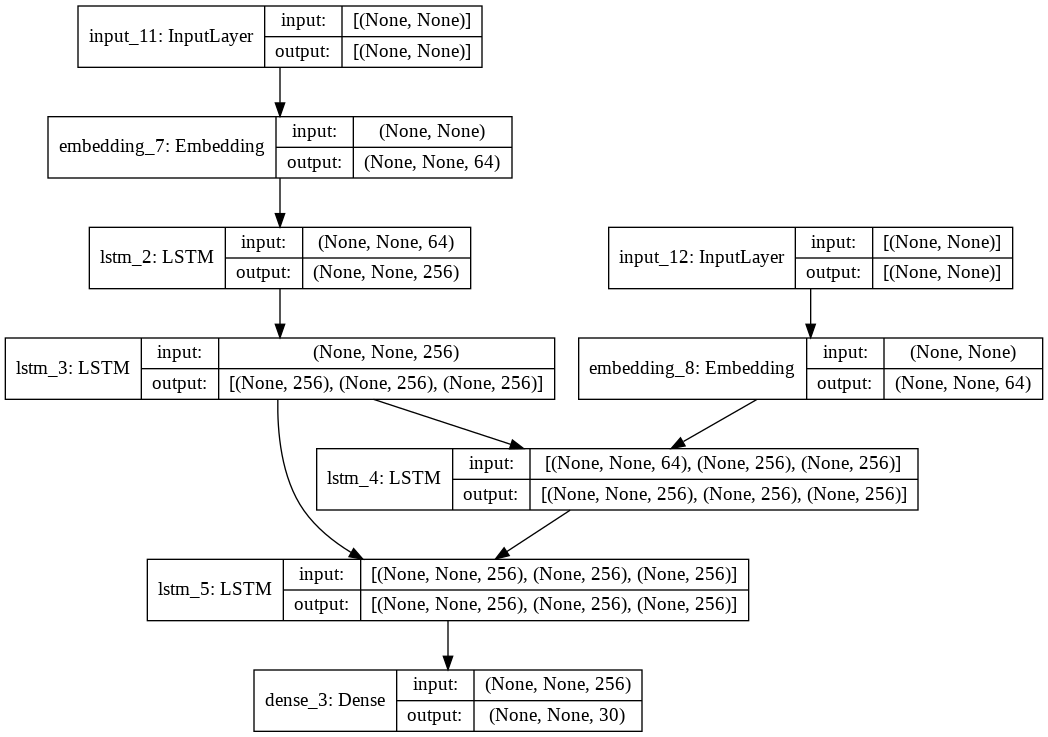

In [65]:
plot_model(model,show_shapes=True)

In [17]:
X_train = [np.array(x) for x in X_train]
print(X_train[:5])

[array([1, 4, 5, 2]), array([ 1,  4,  5,  6,  7,  8,  9, 10,  2]), array([ 1,  4,  5,  6, 11,  2]), array([ 1,  4,  5,  6, 12, 13,  2]), array([ 1,  4,  5,  6, 12, 13,  8,  2])]


In [18]:
Y_train = [np.array(y) for y in Y_train]
print(Y_train[:5])

[array([1, 4, 5, 2]), array([1, 4, 5, 6, 7, 4, 5, 8, 9, 2]), array([ 1, 10,  5, 11, 12, 13,  2]), array([ 1,  4,  5,  6, 10, 14,  2]), array([ 1,  4,  5,  6, 10, 14,  4,  5,  2])]


In [47]:
def generate_batch(X = X_train, y = Y_train, batch_size = 1):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        decoder_input_data[i, t] = word # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [67]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_val)    # Total validation or test samples
batch_size = 64
epochs = 10

In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [78]:
model.fit_generator(generator = generate_batch(X_train, Y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs)

Epoch 1/10
  5/710 [..............................] - ETA: 17s - loss: 0.1871 - acc: 0.8485

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


710/710 [==============================] - 18s 25ms/step - loss: 0.1145 - acc: 0.9133
Epoch 2/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0966 - acc: 0.9260
Epoch 3/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0845 - acc: 0.9348
Epoch 4/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0750 - acc: 0.9415
Epoch 5/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0685 - acc: 0.9458
Epoch 6/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0612 - acc: 0.9512
Epoch 7/10
710/710 [==============================] - 17s 23ms/step - loss: 0.0527 - acc: 0.9573
Epoch 8/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0450 - acc: 0.9638
Epoch 9/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0416 - acc: 0.9659
Epoch 10/10
710/710 [==============================] - 16s 23ms/step - loss: 0.0374 - acc: 0.9694


In [53]:
X_test = tk.encode(lex['test'].input.tolist())
Y_test = tk.encode(lex['test'].output.tolist(),'output')

In [24]:
sd = generate_batch(X_test,Y_test)

In [79]:
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_input = [decoder_state_input_h,decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embedding(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, _,_ = decoder_LSTM(dec_emb2
                                                    ,initial_state=decoder_state_input
                                                    )
decoder_outputs2, state_c2,state_h2 = decoder_LSTM2(decoder_outputs2
                                                    ,initial_state=decoder_state_input
                                                    )
decoder_states2 = [state_c2,state_h2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [56]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     1920        input_8[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
gru_10 (GRU)                    [(None, None, 256),  247296      embedding_6[2][0]                
                                                                 input_10[0][0]             

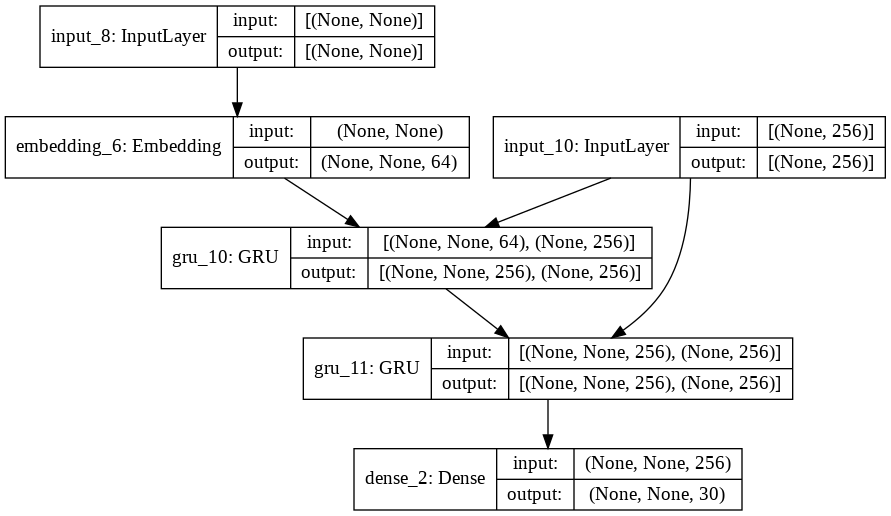

In [57]:
plot_model(decoder_model,show_shapes=True)

In [80]:
def decode_sequence_beam(input_seq,k,num_states=2):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    if num_states==1 :
      states_value = [states_value]
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = 1
    run_condition = [True for i in range(k)]
    # print(len(states_value))
    results = decoder_model.predict([target_seq] + states_value)
    output_tokens = results[0]
    states_values_temp = []
    for m in range(len(results)-1) :
      states_values_temp += [results[m+1]]

    states_values_k = []
    for m in range(k) :
      states_values_k += [states_values_temp]
    #get topk indices
    ind = np.argpartition(np.array(output_tokens[0, -1, :]), -k)[-k:]
    bestk_ind = ind
    output_tokens = np.array(output_tokens[0, -1, :])
    bestk_prob = output_tokens[ind]
    bestk_tot = [([bestk_ind[i]],bestk_prob[i],1) for i in range(k)]
    # print(bestk_tot)

    
    while any(run_condition):
        bestk_tot_new = []
        bestk_prob_new = []
        states_values_k_new = []
        for i in range(k) :
            if run_condition[i] :
                a,b,c = bestk_tot[i]
                target_seq[0,0] = a[-1]
                results = decoder_model.predict([target_seq] + states_values_k[i])
                output_tokens = results[0]
                states_values_temp = []
                for m in range(len(results)-1) :
                  states_values_temp += [results[m+1]]

                states_values_k_temp = []
                for m in range(k) :
                  states_values_k_temp += [states_values_temp]

                states_values_k_new += states_values_k_temp
                ind = np.argpartition(np.array(output_tokens[0, -1, :]), -k)[-k:]
                bestk_ind = ind
                output_tokens = np.array(output_tokens[0, -1, :])
                bestk_prob_temp = output_tokens[ind]
                bestk_tot_temp = [(a+[bestk_ind[j]],b*bestk_prob_temp[j],c+1) for j in range(k)]
                bestk_prob_temp2 = [b*bestk_prob_temp[j] for j in range(k)]
                bestk_prob_new += bestk_prob_temp2
                bestk_tot_new += bestk_tot_temp
            
            else :
                a,b,c = bestk_tot[i]
                bestk_tot_new += [bestk_tot[i]]
                bestk_prob_new += [b]
                states_values_k_new += [states_values_k[i]]

        bestk_prob_new = np.array(bestk_prob_new)
        # print(len(bestk_prob_new),len(bestk_tot_new),len(states_values_k_new))
        ind = np.argpartition(bestk_prob_new,-k)[-k:]
        bestk_tot = [bestk_tot_new[i] for i in ind]
        states_values_k = [states_values_k_new[i] for i in ind]
        run_condition = []
        for ele in bestk_tot :
            a,b,c = ele
            if a[-1]!= 2 and len(a)<=max_target_length :
              run_condition.append(True)
            else :
              run_condition.append(False)

        # print(bestk_tot)

    final_words = []

    for ele in bestk_tot :
      a,b,c = ele
      final_words += [[1]+a]

    return tk.decode(final_words,'output')

In [81]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = 1
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    chars = [1]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 2 :
          stop_condition = True
        chars.append(sampled_token_index)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return tk.decode([chars],'output')[0]

In [84]:
test_gen = generate_batch(X_test, Y_test, batch_size = 1)
k=-1

In [82]:
x1 = tk.encode(['अचीवमेंट'])
x1

[[1, 4, 27, 21, 31, 28, 16, 5, 29, 2]]

In [83]:
decode_sequence(x1)

'aiveivelg'

In [74]:
decode_sequence_beam(x1,4,1)

['aachilelatoo', 'aachilevalot', 'aachilevalut', 'aachilevat']

In [ ]:
lex['test'].input.tolist()[k]

'अचीवमेंट'

In [108]:
k += 1
(input_seq, actual_output), _ = next(test_gen)
# print(input_seq)
decoded_sentence = decode_sequence_beam(input_seq,4)
print('Input Source sentence:', tk.decode([X_test[k]])[0] )
print('Actual Target Translation:', tk.decode([Y_test[k]],mode='output')[0])
print('Predicted Target Translations:', decoded_sentence)

Input Source sentence: अछनेरा
Actual Target Translation: achhanera
Predicted Target Translations: ['acheharuo', 'achehoreo', 'acheiroo', 'achehaur']


In [105]:
print(tk.decode([X_test[k]])[0])

अच्छी


# Romanized

In [ ]:
ta_rom = dict()
ta_rom['rejoined'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['rejoined_aligned_cased'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.cased_nopunct.tsv', sep='\t', header=None, error_bad_lines=False) 
ta_rom['rejoined_aligned'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['split'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.split.tsv', sep='\t', header=None, error_bad_lines=False)

b'Skipping line 1096: expected 2 fields, saw 3\nSkipping line 1581: expected 2 fields, saw 3\n'
b'Skipping line 33794: expected 2 fields, saw 3\nSkipping line 33795: expected 2 fields, saw 3\nSkipping line 33796: expected 2 fields, saw 3\nSkipping line 33798: expected 2 fields, saw 3\nSkipping line 33799: expected 2 fields, saw 3\nSkipping line 33801: expected 2 fields, saw 3\nSkipping line 33802: expected 2 fields, saw 3\nSkipping line 33803: expected 2 fields, saw 3\n'
b'Skipping line 11317: expected 2 fields, saw 4\nSkipping line 16502: expected 2 fields, saw 4\nSkipping line 32577: expected 2 fields, saw 3\nSkipping line 32578: expected 2 fields, saw 3\nSkipping line 32579: expected 2 fields, saw 3\nSkipping line 32581: expected 2 fields, saw 3\nSkipping line 32582: expected 2 fields, saw 3\nSkipping line 32584: expected 2 fields, saw 3\nSkipping line 32585: expected 2 fields, saw 3\nSkipping line 32586: expected 2 fields, saw 3\n'
b'Skipping line 1108: expected 7 fields, saw 9\nSk

In [ ]:
list(ta_rom['rejoined'].iloc[0, 0])[:10]

['ர', 'ே', 'ட', 'ி', 'ய', 'ோ', ' ', 'அ', 'த', 'ி']

In [ ]:
ta_rom['rejoined_aligned_cased']

,0,1
0,ரேடியோ,radio
1,அதிர்வெண்,athirven
2,முடுக்கிகள்,mudikkigal
3,துகள்கள்,thugalkal
4,நேரடியாக,neradiyaga
...,...,...
104779,இவ்விதழின்,ivvithazhin
104780,விலை,vilai
104781,ரூபாய்,roobaay
104782,1.00,1.00


In [ ]:
ta_rom['rejoined_aligned']

NameError: ignored

In [ ]:
ta_rom['split']

,0,1,2,3,4,5,6
0,"ரேடியோ அதிர்வெண் முடுக்கிகள், துகள்கள் நேரடியா...",6,"Radio athirven mudikkigal, thugalkal neradiyag...",6.0,NaN,NaN,NaN
1,மான் விளையாடிக்கொண்டு வந்து உன்னை மோதினால் உன்...,21,Maan vilaiyaadikondu vanthu unnai modhinaal un...,21.0,NaN,NaN,NaN
2,அமிர்தகழி,1,Amirthakazhi,1.0,NaN,NaN,NaN
3,மோகன் லால் குப்தா ஜெய்ப்பூரின் முன்னாள் மேயராக...,12,"Mohan Lal Gupta Jaipaurin munnal mayoragavum, ...",12.0,NaN,NaN,NaN
4,தில்லி மாநில கூட்டுறவு வங்கி லி.,5,Delhi maanila kooturavu vangi li.,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9982,என்றாலும் வில்லியம் இறந்த பிறகான கரோலினின் பணி...,27,Yendraalum William irandha piragaana Carolinin...,27.0,NaN,NaN,NaN
9983,தொல்பொருளியல் அச்சகம் (Archaeopress) என்பது இங...,14,Tholporuliyal achchagam (Archaeopress) yenbath...,14.0,NaN,NaN,NaN
9984,மலைய நாட்டு மன்னனை மலாடர் கோமான் என்று சங்கப்ப...,8,Malaiya naattu mannanai malaadar komaan yendru...,8.0,NaN,NaN,NaN
9985,"அப்படையின் தொகை மிக அருகி இருந்ததோடு, அதனிடம் ...",12,"Appadaiyin thogai miga arugi irunthathodu, ath...",12.0,NaN,NaN,NaN


In [36]:
l1 = np.array([[[2.0975754e-06, 1.1997452e-06, 1.4667853e-04, 1.5162078e-06, 8.0374902e-01,
   1.1032063e-01 ,3.0011556e-04, 1.1470485e-04, 1.5095265e-03, 2.5611497e-03,
   3.0117370e-03 ,2.3502544e-03, 8.1402555e-05, 6.6068387e-03, 2.7699009e-02,
   9.6444995e-04, 2.6303992e-02, 5.2016590e-06, 2.2813273e-03, 1.7525272e-03,
   3.0712271e-04, 7.0323329e-03, 6.3351414e-05, 8.6058344e-04, 4.3101230e-04,
   2.1862783e-05, 4.8190984e-04, 1.0124088e-03, 1.1346481e-05, 1.4743240e-05]]])

In [38]:
l1[0,-1][[1,2,3]]

array([1.1997452e-06, 1.4667853e-04, 1.5162078e-06])